**Kasus dari Senja: Daily number of customers on Desember**

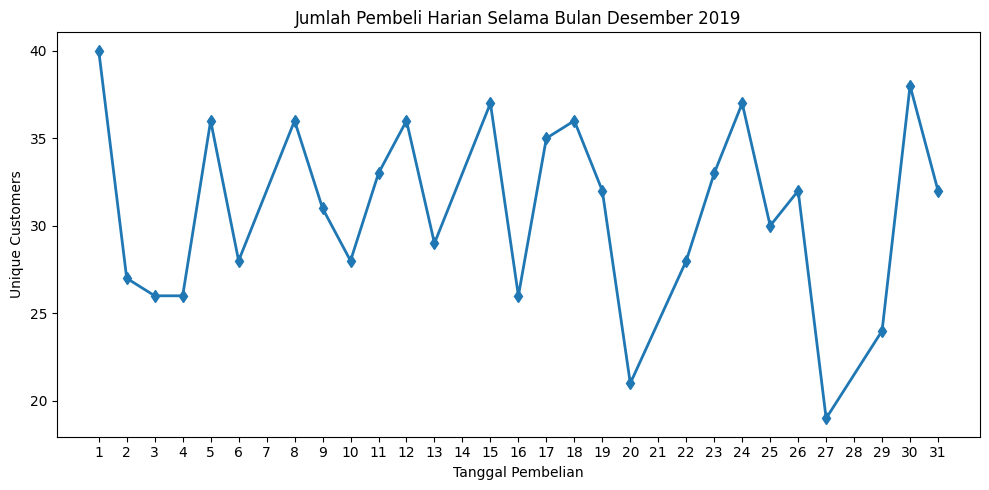

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Membaca dataset
df = pd.read_csv('https://dqlab-dataset.s3-ap-southeast-1.amazonaws.com/retail_raw_reduced.csv')

# Mengubah kolom order_date menjadi tipe data datetime
df['order_date'] = pd.to_datetime(df['order_date'])

# Filter data untuk bulan Desember 2019
december_data = df[(df['order_date'].dt.month == 12) & (df['order_date'].dt.year == 2019)]

# Menghitung jumlah unique customers di tiap tanggal
daily_customers = december_data.groupby(december_data['order_date'].dt.day)['customer_id'].nunique()

# Membuat line chart
plt.figure(figsize=(10, 5))
plt.plot(daily_customers.index, daily_customers.values, marker='d', linestyle='-', linewidth=2)
plt.title('Jumlah Pembeli Harian Selama Bulan Desember 2019')
plt.xlabel('Tanggal Pembelian')
plt.ylabel('Unique Customers')
plt.xticks(range(1, 32))
plt.tight_layout()

# Menampilkan plot
plt.show()


**Case 1: Menentukan Brand top 5**

In [ ]:
# Mengambil informasi top 5 brands berdasarkan quantity
top_brands = december_data.groupby('brand')['quantity'].sum().reset_index()

#Mengurutkan jumlah produk terjual secara menurun
brand_product_count_sorted = top_brands.sort_values(by='quantity',ascending=False)

# Menampilkan top brand 5
top_5_brands = brand_product_count_sorted.head(5)

# Menampilkan brand top 5
print("Penjualan Top 5 Brand:")
for index, row in top_5_brands.iterrows():
    print(f"{row['brand']}: {row['quantity']} produk yang terjual.")

Penjualan Top 5 Brand:
BRAND_S: 2197 produk yang terjual.
BRAND_P: 2194 produk yang terjual.
BRAND_R: 1508 produk yang terjual.
BRAND_C: 1365 produk yang terjual.
BRAND_A: 1315 produk yang terjual.


**Case 2: Multi-line chart daily quantity untuk brand top 5**

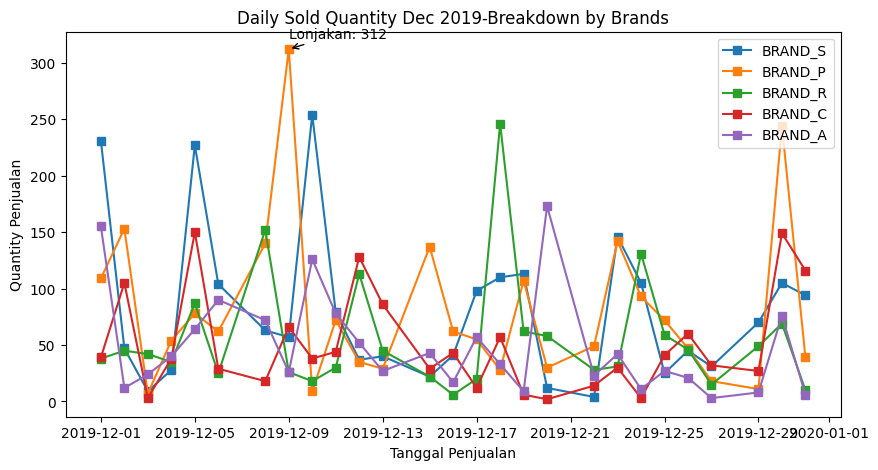

In [ ]:
# Menghitung daily quantity terjual per brand
daily_quantity = december_data.groupby(['order_date', 'brand'])['quantity'].sum().reset_index()

# Mengambil top 5 brand
top_5_brands = december_data.groupby('brand')['quantity'].sum().nlargest(5).index

# Membuat line chart per brand top 5
plt.figure(figsize=(10, 5))
lonjakan_tanggal = None
lonjakan_quantity = None
for brand in top_5_brands:
    brand_data = daily_quantity[daily_quantity['brand'] == brand]
    plt.plot(brand_data['order_date'], brand_data['quantity'], marker='s', linestyle='-', label=brand)
    # Mencari tanggal dengan quantity terbesar untuk setiap brand
    tanggal_lonjakan = brand_data.loc[brand_data['quantity'].idxmax(), 'order_date']
    quantity_lonjakan = brand_data.loc[brand_data['quantity'].idxmax(), 'quantity']
    # Memperbarui informasi lonjakan jika ditemukan tanggal dengan quantity lebih tinggi
    if lonjakan_quantity is None or quantity_lonjakan > lonjakan_quantity:
        lonjakan_tanggal = tanggal_lonjakan
        lonjakan_quantity = quantity_lonjakan

# Menambahkan anotasi pada titik lonjakan
plt.annotate(f'Lonjakan: {lonjakan_quantity}',
             xy=(lonjakan_tanggal, lonjakan_quantity),
             xytext=(lonjakan_tanggal, lonjakan_quantity + 10),
             arrowprops=dict(facecolor='red', arrowstyle='->'),
             ha='left')

# Menambahkan judul, label sumbu, dan legenda
plt.title('Daily Sold Quantity Dec 2019-Breakdown by Brands')
plt.xlabel('Tanggal Penjualan')
plt.ylabel('Quantity Penjualan')
plt.legend()

# Menampilkan line chart
plt.show()

**Case 3: Bar chart tiap produk yang laku**

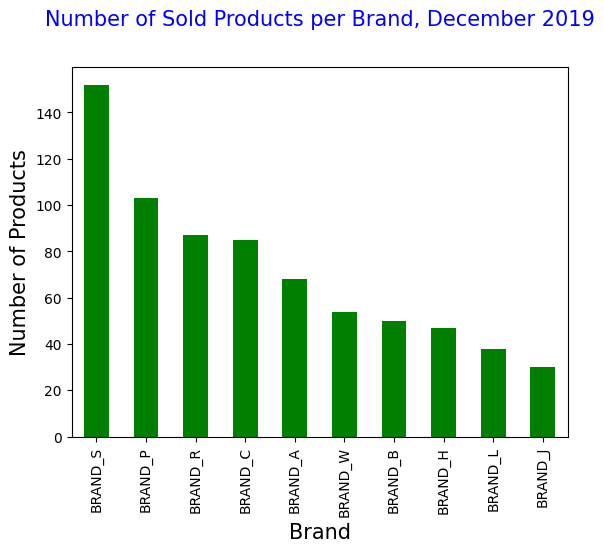

In [16]:
# Menampilkan bar chart jumlah produk terjual per brand
plt.clf()
december_data.groupby('brand')['product_id'].nunique().sort_values(ascending=False).plot(kind='bar', color='green')

# Menambahkan judul dan label sumbu
plt.title('Number of Sold Products per Brand, December 2019',loc='center',pad=30, fontsize=15, color='blue')
plt.xlabel('Brand', fontsize = 15)
plt.ylabel('Number of Products',fontsize = 15)
plt.show()

**Case 4: Penjualan produk diatas 100 dan dibawah 100 selama Desember 2019**

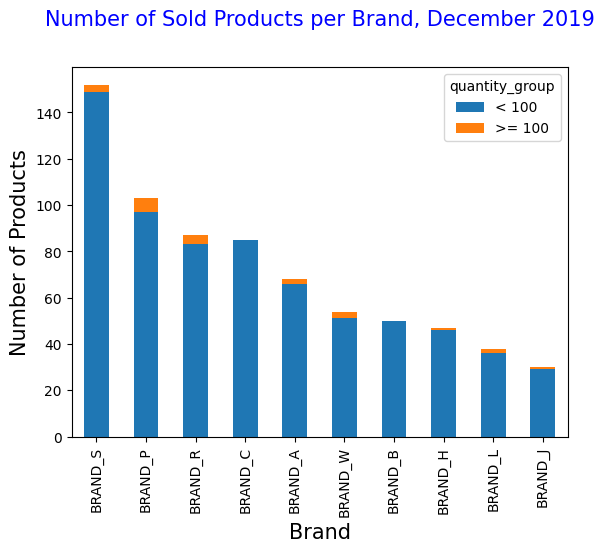

In [15]:
# Membuat dataframe baru, untuk agregat jumlah quantity terjual per product
dataset_top5brand_dec_per_product = december_data.groupby(['brand','product_id'])['quantity'].sum().reset_index()

# beri kolom baru untuk menandai product yang terjual >= 100 dan <100
dataset_top5brand_dec_per_product['quantity_group'] = dataset_top5brand_dec_per_product['quantity'].apply(lambda x: '>= 100' if x>=100 else '< 100')
dataset_top5brand_dec_per_product.sort_values('quantity',ascending=False,inplace=True)

# membuat referensi pengurutan brand berdasarkan banyaknya semua product
s_sort = dataset_top5brand_dec_per_product.groupby('brand')['product_id'].nunique().sort_values(ascending=False)

# plot stacked barchart
dataset_top5brand_dec_per_product.groupby(['brand','quantity_group'])['product_id'].nunique().reindex(index=s_sort.index, level='brand').unstack().plot(kind='bar', stacked=True)
plt.title('Number of Sold Products per Brand, December 2019',loc='center',pad=30, fontsize=15, color='blue')
plt.xlabel('Brand', fontsize = 15)
plt.ylabel('Number of Products',fontsize = 15)
plt.show()

**Case 5: Murah atau mahalkah harga produk brand top 5**

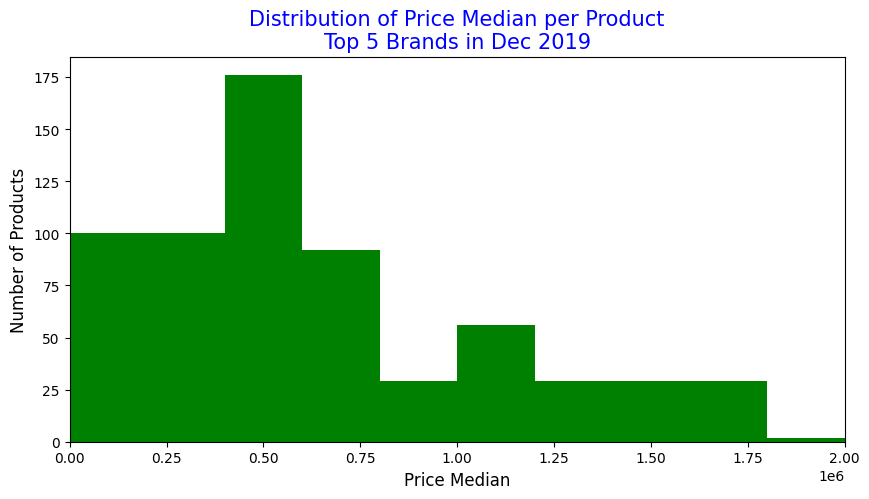

In [18]:
# Membuat histogram
plt.figure(figsize=(10,5))
plt.hist(december_data.groupby('product_id')['item_price'].median(), bins=10, stacked=True, range=(1,2000000), color='green')
plt.title('Distribution of Price Median per Product\nTop 5 Brands in Dec 2019',fontsize=15, color='blue')
plt.xlabel('Price Median', fontsize = 12)
plt.ylabel('Number of Products',fontsize = 12)
plt.xlim(xmin=0,xmax=2000000)
# Menampilkan histogram
plt.show()

**Case 6a: Korelasi quantity vs GMV**

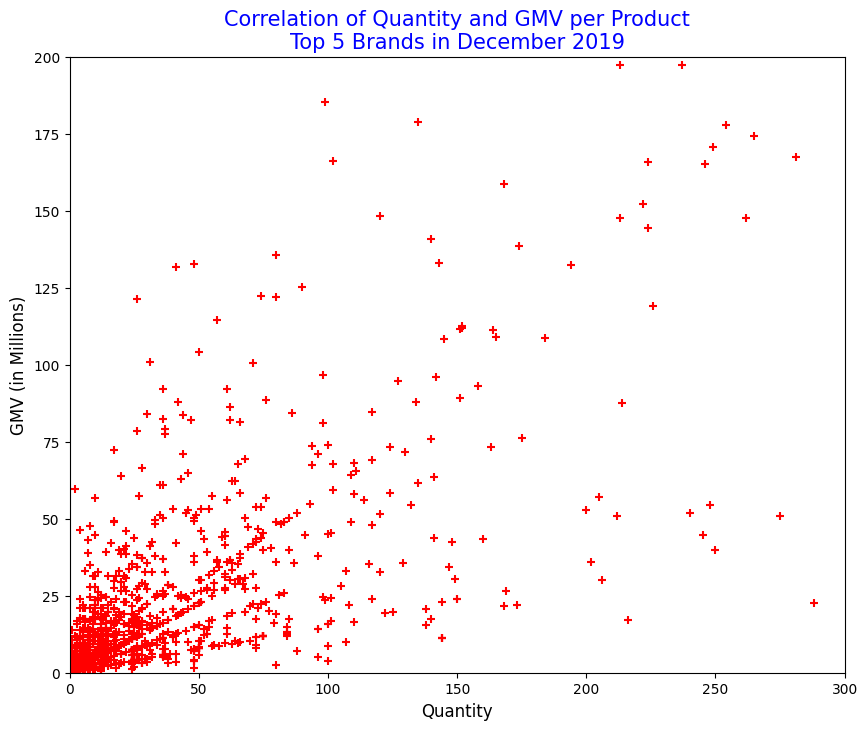

In [31]:
#agregat per product
df['GMV'] = df['quantity'] * df['item_price']
data_product = df.groupby('product_id').agg({'quantity': 'sum', 'GMV': 'sum', 'item_price': 'median'}).reset_index()
#scatter plot
plt.figure(figsize=(10,8))
plt.scatter(data_product['quantity'],data_product['GMV'], marker='+', color='red')
plt.title('Correlation of Quantity and GMV per Product\nTop 5 Brands in December 2019',fontsize=15, color='blue')
plt.xlabel('Quantity', fontsize = 12)
plt.ylabel('GMV (in Millions)',fontsize = 12)
plt.xlim(xmin=0,xmax=300)
plt.ylim(ymin=0,ymax=200000000)
labels, locations = plt.yticks()
plt.yticks(labels, (labels/1000000).astype(int))
plt.show()

**Case 6b: Korelasi median harga vs quantity**

<Figure size 640x480 with 0 Axes>

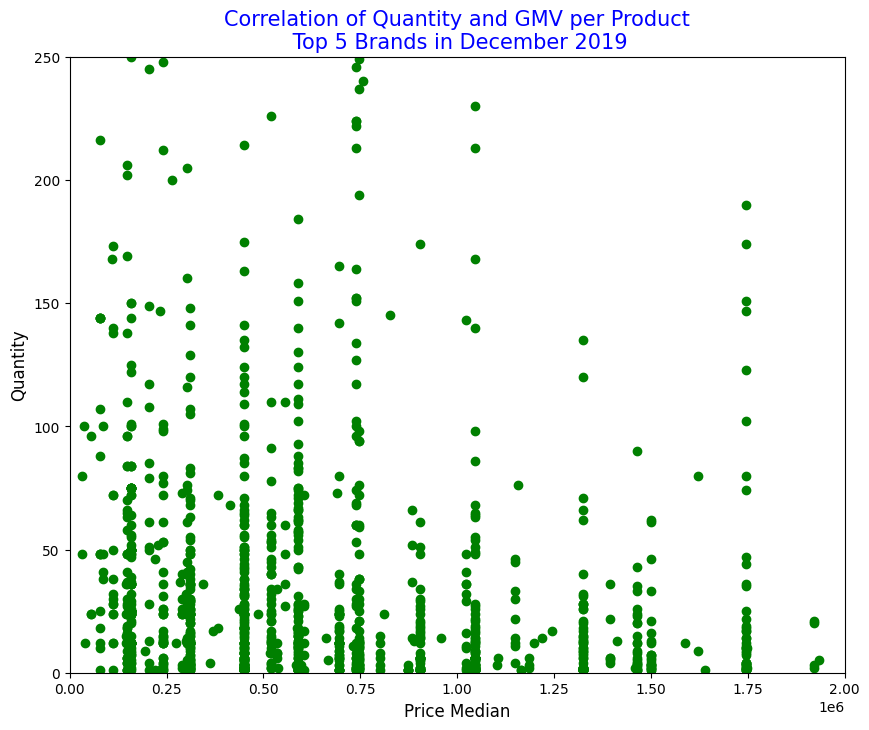

In [40]:
import matplotlib.pyplot as plt
plt.clf()
#agregat per product
df['GMV'] = df['quantity'] * df['item_price']
data_product = df.groupby('product_id').agg({'quantity': 'sum', 'GMV': 'sum', 'item_price': 'median'}).reset_index()
#scatter plot
plt.figure(figsize=(10,8))
plt.scatter(data_product['item_price'],data_product['quantity'], marker='o', color='green')
plt.title('Correlation of Quantity and GMV per Product\n Top 5 Brands in December 2019',fontsize=15, color='blue')
plt.xlabel('Price Median', fontsize = 12)
plt.ylabel('Quantity',fontsize = 12)
plt.xlim(xmin=0,xmax=2000000)
plt.ylim(ymin=0,ymax=250)
plt.show()